# Variational approximation demo.

This notebook shows how significant of the diagonal approximation is.

*Keisuke Fujii 15th Oct. 2016*

We compare

+ Simple regression by normal Gaussian Process.      
+ Regression by GPinv with fullrank covariance.
+ Regression by GPinv with diagonal covariance.
+ Regression by GPinv with semi-diagonal covariance.

## Import several libraries including GPinv

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
# Import GPinv
import GPinv
# Import GPflow as comparison
import GPflow

# import graphical things
import seaborn as sns

sns.set_context('poster')
sns.set_style('ticks')
import matplotlib
fontprop = matplotlib.font_manager.FontProperties(fname="/usr/share/fonts/truetype/ttf-dejavu//")
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.it'] = 'DejaVu Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'DejaVu Sans:bold'

current_palette = sns.color_palette()

## Make random generator static

In [2]:
rng = np.random.RandomState(0)

# Simple regression

## Synthetic data

In [3]:
X = rng.randn(40,1)*2.0
Y = np.sin(X) + rng.randn(40,1)*0.2

## GPflow.gpr.GPR

In [4]:
m_gpflow = GPflow.gpr.GPR(X, Y, GPflow.kernels.RBF(1))
rslt = m_gpflow.optimize()
rslt

      fun: -2.2543466743312841
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.12197336e-07,  -7.19758923e-07,   8.27806365e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 15
      nit: 9
   status: 0
  success: True
        x: array([ 0.10943095,  1.66329614, -3.65171248])

In [5]:
X_new = np.linspace(-3.1,3.1,40).reshape(-1,1)
f_mu, f_var = m_gpflow.predict_f(X_new)

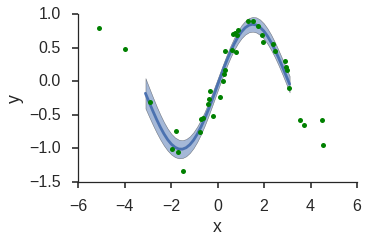

In [6]:
plt.figure(figsize=(5,3))
plt.fill_between(X_new.flatten(), (f_mu+2*np.sqrt(f_var)).flatten(), (f_mu-2*np.sqrt(f_var)).flatten(), alpha=0.5)
plt.plot(X_new, f_mu)
plt.plot(X, Y, 'go', ms = 5)
plt.xlabel('x')
plt.ylabel('y')

sns.despine()
plt.savefig('figs/simple_regression.pdf')

## GPinv.stvgp

In GPinv, we need custom likelihood, where at least the conditional likelihood of the data (**logp**) is specified.

The likelihood class should inherite GPinv.likelihood.Likelihood.

In [7]:
class GaussianLikelihood(GPinv.likelihoods.Likelihood):
    def __init__(self):
        GPinv.likelihoods.Likelihood.__init__(self)
        # variance parameter is assigned as GPinv.param.Param
        self.variance = GPinv.param.Param(1, GPinv.transforms.positive)
    
    def logp(self, F, Y):
        return GPinv.densities.gaussian(Y, F, self.variance)

### Function for display

In [8]:
# Fullrank covariance
m_fullrank = GPinv.stvgp.StVGP(X, Y, GPinv.kernels.RBF(1, output_dim=1), 
                               likelihood=GaussianLikelihood(),
                               num_samples = 3)

In [9]:
# Diagonal covariance
m_diagonal = GPinv.stvgp.StVGP(X, Y, GPinv.kernels.RBF(1, output_dim=1), 
                               likelihood=GaussianLikelihood(),
                               q_shape='diagonal', num_samples = 3)

In [10]:
# Semidiagonal covariance with rank-2
m_semidiag2 = GPinv.stvgp.StVGP(X, Y, GPinv.kernels.RBF(1, output_dim=1), 
                               likelihood=GaussianLikelihood(),
                               q_shape=2, num_samples = 3)

In [11]:
# Semidiagonal covariance with rank-2
m_semidiag3 = GPinv.stvgp.StVGP(X, Y, GPinv.kernels.RBF(1, output_dim=1), 
                               likelihood=GaussianLikelihood(),
                               q_shape=3, num_samples = 3)

# Optimize

In [12]:
# This function visualizes the iteration.
from IPython import display
    
def optimize(model):
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.05
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                               20, 0.9)
    trainer = tf.train.AdamOptimizer(learning_rate)

    logf = []
    def logger(x):
        if (logger.i % 5) == 0:
            obj = -model._objective(x)[0]
            logf.append(obj)
            # display
            if (logger.i % 100) ==0:
                plt.clf()
                plt.plot(logf, '-ko', markersize=3, linewidth=1)
                plt.ylabel('ELBO')
                plt.xlabel('iteration')
                display.display(plt.gcf())
                display.clear_output(wait=True)
        logger.i+=1
    logger.i = 0
    
    plt.figure(figsize=(6,3))
    # optimization by tf.train
    _= model.optimize(method=trainer, callback=logger, maxiter=1500, global_step = global_step)
    display.clear_output(wait=True)
    return logf

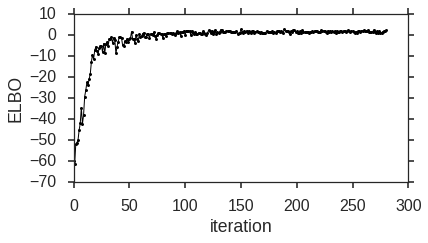

In [13]:
logf_fullrank = optimize(m_fullrank)

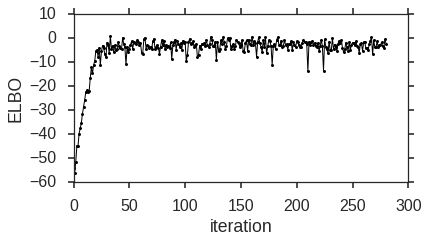

In [14]:
logf_diag = optimize(m_diagonal)

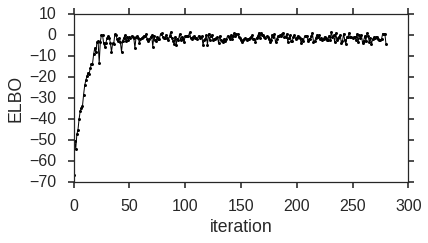

In [15]:
logf_semidiag2 = optimize(m_semidiag2)

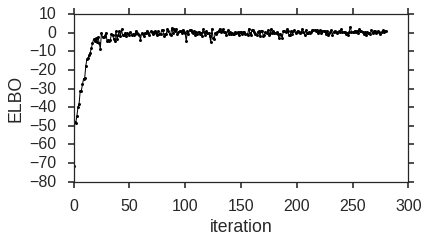

In [16]:
logf_semidiag3 = optimize(m_semidiag3)

### Compare results

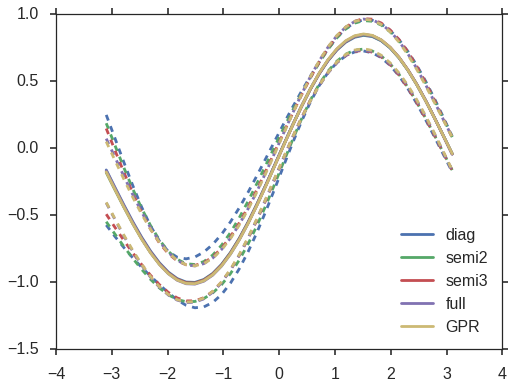

In [17]:
models = [m_diagonal, m_semidiag2, m_semidiag3, m_fullrank, m_gpflow]
model_names = ['diag', 'semi2', 'semi3', 'full', 'GPR']

plt.figure(figsize=(8,6))
for i in range(len(models)):
    model = models[i]
    f_mu, f_var = model.predict_f(X_new)
    plt.plot(X_new, f_mu+2*np.sqrt(f_var), '--', color = current_palette[i])
    plt.plot(X_new, f_mu-2*np.sqrt(f_var), '--', color = current_palette[i])
    plt.plot(X_new, f_mu, '-', label=model_names[i], color=current_palette[i])
plt.legend(loc='best')